# DYNAMITE and Bayes-LOSVD

BayesLOSVD is a tool for extraction of histogrammed LOSVDs from galaxy-spectra. This notebook shows how to use BayesLOSVD output with DYNAMITE.

## Data Preparation 

There are three steps in the data-preparation:

1. convert Bayes-LOSVD output to ECSV file
2. add the PSF to the ECSV file header
3. create auxillary files aperture.dat and bins.dat


I'll demonstrate these steps using Michela's CR galaxy IC0719.

**Note for public release** - swap to the followwing: I'll demonstrate these steps using the example `NGC0000-SP_results.hdf5`. This file comes from running the example dataset provided with Bayes-LOSVD, and it contains LOSVDs for every spatial bin of a galaxy. See the [BayesLOSVD documentation](https://github.com/jfalconbarroso/BAYES-LOSVD) for instructions on how to create such files. For convenience, a copy of `NGC0000-SP_results.hdf5` is provided in this directory.

#### Convert Bayes-LOSVD output to ECSV file

First let's make an "empty" BayesLOSVD object,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynamite as dyn

In [2]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(weight=1.,
                                       hist_width=1,
                                       hist_center=0,
                                       hist_bins=0,
                                       type='BayesLOSVD')

We've had to provide some default values for certain keyword parameters, but they won't be used. All we want it to able to use the method `write_losvds_to_ecsv_format` to convert the results to the required ECSV format,

In [3]:
filename = 'IC0719_input/IC0719_CaT_1-SP_results.hdf5'
BayesLOSVD.write_losvds_to_ecsv_format(filename,
                                       outfile='IC0719_input/bayes_losvd_kins.ecsv')

This creates a file `bayes_losvd_kins.ecsv`.

#### add the PSF to the ECSV file header

Next add the PSF into the header of this file. This is specified as a Gaussian mixture with a list of sigmas and weights. Change these numbers to the correct PSF for your data,

In [4]:
BayesLOSVD.add_psf_to_datafile(sigma=[1.,2.],
                               weight=[0.6,0.4],
                               datafile='IC0719_input/bayes_losvd_kins.ecsv')

#### create auxillary files aperture.dat and bins.dat

We can now re-read the ECSV table into a new `BayesLOSVD` object, 

In [5]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile='IC0719_input/bayes_losvd_kins.ecsv',
                                       weight=1.,
                                       type='BayesLOSVD')

in order to create the `aperture.dat` and `bins.dat` files. These are used by DYNMAITE to bin orbits in order to compare them to the data,

In [6]:
BayesLOSVD.write_aperture_and_bin_files(filename=filename,
                                        angle_deg=0.,
                                        aperture_filename='IC0719_input/aperture.dat',
                                        bin_filename='IC0719_input/bins.dat')

We can look at the binning using [`plotbin`](https://pypi.org/project/plotbin/),

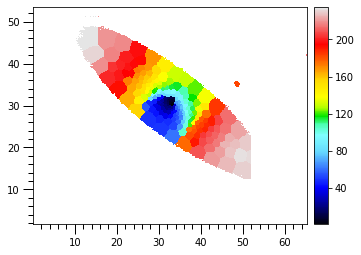

In [7]:
from plotbin import display_pixels

display_pixels.display_pixels(BayesLOSVD.xx,
                              BayesLOSVD.yy,
                              BayesLOSVD.binID_dynamite,
                              pixelsize=0.2,
                              colorbar=True)

**Note on bin IDs**: the binIDs we use in DYNMAITE are slightly different from the binIDs which are used in BayesLOSVD e.g. if we compare the minimum, maximum, and range of the ID's,

In [8]:
min_bin = np.min(BayesLOSVD.binID_BayesLOSVD)
max_bin = np.max(BayesLOSVD.binID_BayesLOSVD)
print('BinID BayesLOSVD: min, max, range =', min_bin, max_bin, max_bin-min_bin)

min_bin = np.min(BayesLOSVD.binID_dynamite)
max_bin = np.max(BayesLOSVD.binID_dynamite)
print('BinID DYNAIMTE: min, max, range =', min_bin, max_bin, max_bin-min_bin)

BinID BayesLOSVD: min, max, range = 0 237 237
BinID DYNAIMTE: min, max, range = 1 235 234


The reason these are different is that:

1. BayesLOSVD bins are zero-indexed, while DYNAMITE (specifically legacy fortran code) requires that  bins are 1-indexed,
2.  BayesLOSVD bins not necessarily continuous as some bins might be masked, while DYNATIMTE assumes continuously numbered bins.

You won't need to worry about this difference when running DYNAMITE, but be aware of it for any later analysis!

All of these above steps should be done before the main DYNMAITE run. We can now look at the resulting file and explore some of the output.

## Looking at the BayesLOSVD output

We can read create a new BayesLOSVD object from the files we have just created,

In [9]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile='IC0719_input/bayes_losvd_kins.ecsv',
                                       aperturefile='IC0719_input/aperture.dat',
                                       binfile='IC0719_input/bins.dat',
                                       weight=1.,
                                       type='BayesLOSVD')

The data is stored in the data attribute,

In [10]:
BayesLOSVD.data

binID_BayesLOSVD,binID_dynamite,losvd [35],dlosvd [35],v,sigma
int64,int64,float64,float64,float64,float64
0,1,0.015259378139774543 .. 0.0019416323497681881,0.01989741285762346 .. 0.005968342942902846,25.139417714854343,150.30443226059708
1,2,0.004106415902383198 .. 0.004508561382520821,0.011563090410035497 .. 0.012054460545721686,20.64428749441824,135.913029588071
2,3,0.007710072525254317 .. 0.015386889344653404,0.01510201752165599 .. 0.016906022327590003,12.405493855238928,155.33695847562882
3,4,0.004090768456268483 .. 0.0007614242053367949,0.01024960639403547 .. 0.002376875278290962,28.126960053791034,122.30574005867527
4,5,0.0018553695864067883 .. 0.002205535931192645,0.005951478462937457 .. 0.006721059434023896,13.213971588565506,114.6056209979196
5,6,0.0189432749850374 .. 0.005585052051007471,0.09528282444614967 .. 0.08714230636193271,39.94863636717035,171.18152737870957
6,7,0.019946842755926494 .. 0.002535855487729973,0.018711449668939888 .. 0.0078523083547063,42.91353616565235,158.24235963279546
7,8,0.0043715624686085875 .. 0.0019774594743697392,0.012516282251890123 .. 0.00635984346952707,26.973097959151097,125.46661842022787
8,9,0.013105487122553274 .. 0.001582232344009336,0.016294123929419715 .. 0.005274471848778314,29.120703908039957,141.27489949798658


This has columns for the BayesLOSVD and DYNMAITE binIDs, the LOSVD itself (`losvd`), the error on the LOSVD (`dlosvd`), and its mean `v` and standard deviation `sigma`.

BayesLOSVD represents the LOSVD as a sequence of weights $L_i$ in velocity bins $v_i$. Details of the velocity array are stored as metadata to the data table,

In [11]:
print('Bayes-LOSVD table contains meta-data about: ', BayesLOSVD.data.meta.keys())
print('')
print('     velocity spacing of bins = ', BayesLOSVD.data.meta['dv'])
print('     number of spatial bins = ', BayesLOSVD.data.meta['nbins'])
print('     number of velocty bins = ', BayesLOSVD.data.meta['nvbins'])
print('     velocty bin centers = ', BayesLOSVD.data.meta['vcent'])
print('     PSF parameters = ', BayesLOSVD.data.meta['PSF'])

Bayes-LOSVD table contains meta-data about:  odict_keys(['dv', 'nbins', 'nvbins', 'vcent', 'PSF'])

     velocity spacing of bins =  40.0
     number of spatial bins =  235
     number of velocty bins =  35
     velocty bin centers =  [680.0, 640.0, 600.0, 560.0, 520.0, 480.0, 440.0, 400.0, 360.0, 320.0, 280.0, 240.0, 200.0, 160.0, 120.0, 80.0, 40.0, 0.0, -40.0, -80.0, -120.0, -160.0, -200.0, -240.0, -280.0, -320.0, -360.0, -400.0, -440.0, -480.0, -520.0, -560.0, -600.0, -640.0, -680.0]
     PSF parameters =  {'sigma': [1.0, 2.0], 'weight': [0.6, 0.4]}


What exactly is in the `losvd` and `dlosvd` columns above? BayesLOSVD calculates the multi-dimensional posterior on the LOSVD weights $L_i$. The columns in the table above give the median and 68% Bayesian credible intervals for the weight in each velocity bin.

One point to consider is normalisation. Internally in BayesLOSVD, the weights are normnalised correctly to sum to 1 (acheieved by using the `simplex` datatype in STAN) i.e. 

$$
\sum_i L_i = 1
$$

Unfortuneately, the correct normalisation is not retained when we keep only the median values of LOSVD weights per bin. Let's call the median value,

$$
l_i = \mathrm{median}(L_{i})
$$

This $l_i$ is what is given in the `losvd` column above of the BayesLOSVD datatable. How are the $l_i$ normalised? Let's look at a histogram of the sums of the $l_i$ in each spatial bin,

Text(0.5, 1.0, 'LOSVD normalisation in different spatial bins')

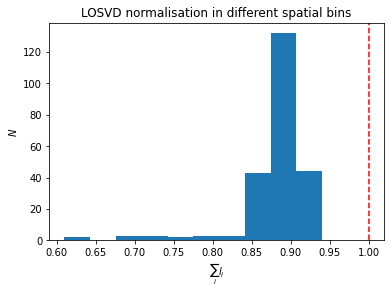

In [12]:
plt.hist(np.sum(BayesLOSVD.data['losvd'], 1))
plt.axvline(1., ls='--', color='r')
plt.gca().set_xlabel('$\sum_i l_{i}$')
plt.gca().set_ylabel('$N$')
plt.gca().set_title('LOSVD normalisation in different spatial bins')

This peaks around 0.9 and, in some cases, is as low as 0.6! It will be important to acccount for this. For example, when calculating moments of the LOSVDs we will have to re-normalise. Let's define the re-normalised `losvd` as

$$
\hat{l}_{i} = \frac{l_{i}}{\sum_i l_{i}}
$$

This quantity $\hat{l}_{i}$ is what should be used to make point estimates of the the mean and standard deviation LOSVD

$$
v = \sum_i v_i * \hat{l}_{i}
$$

$$
\sigma = \left[ \sum_i (v_i-v)^2 * \hat{l}_{i} \right]^{\frac{1}{2}}
$$

These expressions are used to calculate the `v` and `sigma` columns of the data table. Let's plot a few examples of LOSVDs and their Gaussian approximations using these `v` and `sigma` in different spatial bins,

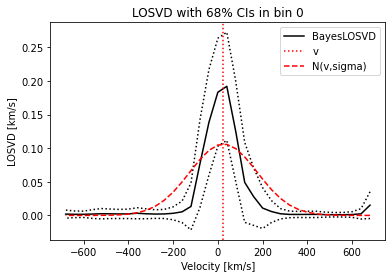

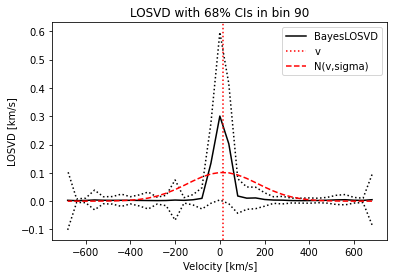

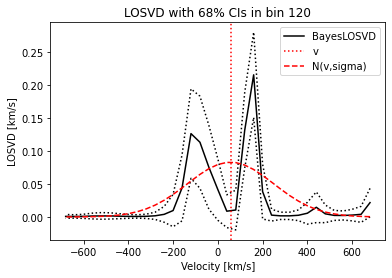

In [13]:
from scipy import stats

for bin_idx in [0, 90, 120]:
    mu = BayesLOSVD.data['losvd'][bin_idx,:]
    sig = BayesLOSVD.data['dlosvd'][bin_idx,:]
    vcent = BayesLOSVD.data.meta['vcent']
    plt.plot(vcent, mu, '-k', label='BayesLOSVD')
    plt.plot(vcent, mu+sig, ':k')
    plt.plot(vcent, mu-sig, ':k')
    v, sig = BayesLOSVD.data['v'][bin_idx], BayesLOSVD.data['sigma'][bin_idx]
    plt.gca().axvline(v, color='r', ls=':', label='v')
    nrm = stats.norm(v, sig)
    pdf = nrm.pdf(vcent)
    plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='N(v,sigma)')
    plt.gca().set_xlabel('Velocity [km/s]')
    plt.gca().set_ylabel('LOSVD [km/s]')
    _ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_idx}')
    plt.gca().legend()
    plt.show()

In the final example, the LOSVD is bimodal, and this is clearly not well matched at all by the Gaussian. But in the previous two, unimodal, examples, the Gaussian approximations are much wider that the histtogrammed LOSVDs. Why is this? Let's look at the two unimodal LOSVDs again, this time on a log-scale,

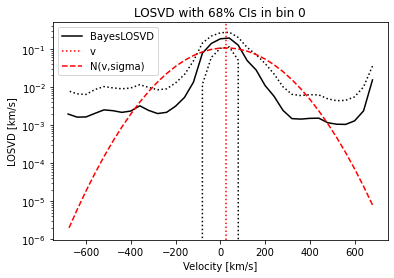

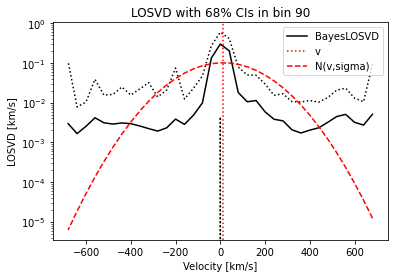

In [14]:
for bin_idx in [0, 90]:
    mu = BayesLOSVD.data['losvd'][bin_idx,:]
    sig = BayesLOSVD.data['dlosvd'][bin_idx,:]
    vcent = BayesLOSVD.data.meta['vcent']
    plt.plot(vcent, mu, '-k', label='BayesLOSVD')
    plt.plot(vcent, mu+sig, ':k')
    plt.plot(vcent, mu-sig, ':k')
    v, sig = BayesLOSVD.data['v'][bin_idx], BayesLOSVD.data['sigma'][bin_idx]
    plt.gca().axvline(v, color='r', ls=':', label='v')
    nrm = stats.norm(v, sig)
    pdf = nrm.pdf(vcent)
    plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='N(v,sigma)')
    plt.gca().set_xlabel('Velocity [km/s]')
    plt.gca().set_ylabel('LOSVD [km/s]')
    _ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_idx}')
    plt.gca().legend()
    plt.gca().set_yscale('log')
    plt.show()

BayesLOSVD does not force the LOSVD to decay at large velocities. The very fat tails give rise to very large standard deviations, and hence these Gaussian approximations look very wrong. These `sigma` are unrepresentative of the width of the main body of the distribution. So, sigma maps for BayesLOSVD output would likely be useless. Quantile maps may be better.

## Running DYNAMITE

There is a configuration file `IC0719_dynmaite_config.yaml` in this directory. The relevant part of the config file where we specify that the kinematics come from BayesLOSVD is the following,

    system_components:
        ...
        stars:
            ...
            kinematics:
                MUSE_calcium_triplet:
                    weight: 1.0
                    type: BayesLOSVD
                    datafile: "bayes_losvd_kins.ecsv"
                    aperturefile: "aperture.dat"
                    binfile: "bins.dat"

The name `MUSE_calcium_triplet` could be any name we wish to give the this kinematic dataset. The `type` must be `BayesLOSVD`, and the filenames are those produced in the data-preparaition step.  

In [27]:
fname = 'IC0719_dynamite_config.yaml'
c = dyn.config_reader.Configuration(fname, reset_logging=True)
c.remove_all_existing_output(wipe_all=True)

[INFO] 18:13:42 - dynamite.config_reader.Configuration - Resetting logging configuration
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Resetting logging configuration
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Resetting logging configuration
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Resetting logging configuration
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Resetting logging configuration
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Config file IC0719_dynamite_config.yaml read.
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Config file IC0719_dynamite_config.yaml read.
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Config file IC0719_dynamite_config.yaml read.
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Config file IC0719_dynamite_config.yaml read.
[INFO] 18:13:42 - dynamite.config_reader.Configuration - Config file IC0719_dynamite_config.yaml read.
[INFO] 18:13:42 - dynamite.config_reader

[INFO] 18:13:43 - dynamite.config_reader.Configuration - Instantiated AllModels object
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Instantiated AllModels object
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Instantiated AllModels object
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Instantiated AllModels object
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Instantiated AllModels object
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Config file backup: IC0719_output/IC0719_dynamite_config_001.yaml
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Config file backup: IC0719_output/IC0719_dynamite_config_001.yaml
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Config file backup: IC0719_output/IC0719_dynamite_config_001.yaml
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Config file backup: IC0719_output/IC0719_dynamite_config_001.yaml
[INFO] 18:13:43 - dynamite.config_reader.Configuration - Config file back

Some quantites are automatically set based on information in the header 

In [35]:
stars = c.system.get_component_from_name('stars')
BayesLOSVD_kin_data = stars.kinematic_data[0]

print('Histogram width for orbits = ', BayesLOSVD_kin_data.hist_width)
print('Histogram center for orbits = ', BayesLOSVD_kin_data.hist_center)
print('Histogram n_bins for orbits = ', BayesLOSVD_kin_data.hist_bins)

print('Histogram width for orbits = ', BayesLOSVD_kin_data.hist_width)
print('Histogram center for orbits = ', BayesLOSVD_kin_data.hist_center)
print('Histogram n_bins for orbits = ', BayesLOSVD_kin_data.hist_bins)



Histogram width for orbits =  1400.0
Histogram center for orbits =  0.0
Histogram n_bins for orbits =  350


In [28]:
parset0 = c.all_models.parspace.get_parset()

mod0 = dyn.model.Model()
